In [1]:
import pandas as pd
import numpy as np
import requests
import tweepy
import os
import json
import time
import re
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
from skimage import io

## Gather Data

### Twitter archive enhanced file

In [2]:
# read csv as a pandas dataframe
twitter_archive = pd.read_csv('twitter-archive-enhanced.csv')
twitter_archive.head()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,None,None
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,None,None,None,None
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,None,None,None,None
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,None,None,None,None


In [3]:
twitter_archive.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
tweet_id                      2356 non-null int64
in_reply_to_status_id         78 non-null float64
in_reply_to_user_id           78 non-null float64
timestamp                     2356 non-null object
source                        2356 non-null object
text                          2356 non-null object
retweeted_status_id           181 non-null float64
retweeted_status_user_id      181 non-null float64
retweeted_status_timestamp    181 non-null object
expanded_urls                 2297 non-null object
rating_numerator              2356 non-null int64
rating_denominator            2356 non-null int64
name                          2356 non-null object
doggo                         2356 non-null object
floofer                       2356 non-null object
pupper                        2356 non-null object
puppo                         2356 non-null object
dtypes: float64(4), int64(3), ob

### Image prediction file download 

In [4]:
# Download the image predictions file using requests library

url="https://d17h27t6h515a5.cloudfront.net/topher/2017/August/599fd2ad_image-predictions/image-predictions.tsv"
response = requests.get(url)

# Save the response content to a tab-separated (tsv) file on our current root folder

with open('image_predictions.tsv', 'wb') as file:
    file.write(response.content)
    
# Read and display the image predictions file content

image_predictions = pd.read_csv('image_predictions.tsv', sep='\t')


In [5]:
image_predictions.head()

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True


### Twitter Tweets API

In [6]:
CONSUMER_KEY = ""
CONSUMER_SECRET = ""
OAUTH_TOKEN = ""
OAUTH_TOKEN_SECRET = ""
auth = tweepy.OAuthHandler(CONSUMER_KEY, CONSUMER_SECRET)
auth.set_access_token(OAUTH_TOKEN, OAUTH_TOKEN_SECRET)
api = tweepy.API(auth)

In [7]:
# List of the error tweets
error_list = []
# List of tweets
df_list = []
# Calculate the time of execution
start = time.time()

# For loop which will add each available tweet json to df_list
for tweet_id in twitter_archive['tweet_id']:
    try:
        tweet = api.get_status(tweet_id, tweet_mode='extended',
                               wait_on_rate_limit = True, wait_on_rate_limit_notify = True)._json 
        favorites = tweet['favorite_count'] # How many favorites the tweet had
        retweets = tweet['retweet_count'] # Count of the retweet
        user_followers = tweet['user']['followers_count'] # How many followers the user had
        user_favourites = tweet['user']['favourites_count'] # How many favorites the user had
        date_time = tweet['created_at'] # The date and time of the creation
        
        df_list.append({'tweet_id': int(tweet_id),
                        'favorites': int(favorites),
                        'retweets': int(retweets),
                        'user_followers': int(user_followers),
                        'user_favourites': int(user_favourites),
                        'date_time': pd.to_datetime(date_time)})
    except Exception as e:
        print(str(tweet_id)+ " _ " + str(e))
        error_list.append(tweet_id)
# Calculate the time of excution
end = time.time()
print(end - start)

888202515573088257 _ [{'code': 144, 'message': 'No status found with that ID.'}]
873697596434513921 _ [{'code': 144, 'message': 'No status found with that ID.'}]
872668790621863937 _ [{'code': 144, 'message': 'No status found with that ID.'}]
869988702071779329 _ [{'code': 144, 'message': 'No status found with that ID.'}]
866816280283807744 _ [{'code': 144, 'message': 'No status found with that ID.'}]
861769973181624320 _ [{'code': 144, 'message': 'No status found with that ID.'}]
845459076796616705 _ [{'code': 144, 'message': 'No status found with that ID.'}]
842892208864923648 _ [{'code': 144, 'message': 'No status found with that ID.'}]
837012587749474308 _ [{'code': 144, 'message': 'No status found with that ID.'}]
827228250799742977 _ [{'code': 144, 'message': 'No status found with that ID.'}]
802247111496568832 _ [{'code': 144, 'message': 'No status found with that ID.'}]
775096608509886464 _ [{'code': 144, 'message': 'No status found with that ID.'}]
770743923962707968 _ [{'code

In [8]:
# length of the result list
print("The length of the result", len(df_list))

# length of the error list
print("The length of the errors", len(error_list))

The length of the result 2342
The length of the errors 14


The lengh of the result 2342
& the lengh of the errors 14

In [9]:
# Create DataFrames from list of dictionaries
json_tweets = pd.DataFrame(df_list, columns = ['tweet_id', 'favorites', 'retweets',
                                               'user_followers', 'user_favourites', 'date_time'])
# Save the dataFrame in file
json_tweets.to_csv('tweet_json.txt', encoding = 'utf-8', index=False)

## Assess Data

#### Check tweet_json.txt file content

In [10]:
# Read the saved tweet_json.txt file into a dataframe
tweet_data = pd.read_csv('tweet_json.txt', encoding = 'utf-8')
tweet_data

,tweet_id,favorites,retweets,user_followers,user_favourites,date_time
0,892420643555336193,38221,8374,7431629,139602,2017-08-01 16:23:56
1,892177421306343426,32767,6182,7431629,139602,2017-08-01 00:17:27
2,891815181378084864,24674,4091,7431629,139602,2017-07-31 00:18:03
3,891689557279858688,41551,8512,7431630,139602,2017-07-30 15:58:51
4,891327558926688256,39737,9218,7431630,139602,2017-07-29 16:00:24
5,891087950875897856,19946,3065,7431630,139602,2017-07-29 00:08:17
6,890971913173991426,11670,2034,7431630,139602,2017-07-28 16:27:12
7,890729181411237888,64506,18583,7431630,139602,2017-07-28 00:22:40
8,890609185150312448,27415,4207,7431630,139602,2017-07-27 16:25:51
9,890240255349198849,31455,7275,7431630,139602,2017-07-26 15:59:51


#### Check twitter-archive-enhanced.csv file content

In [11]:
twitter_archive

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,None,None
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,None,None,None,None
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,None,None,None,None
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,None,None,None,None
5,891087950875897856,NaN,NaN,2017-07-29 00:08:17 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here we have a majestic great white breaching ...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891087950...,13,10,None,None,None,None,None
6,890971913173991426,NaN,NaN,2017-07-28 16:27:12 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Meet Jax. He enjoys ice cream so much he gets ...,NaN,NaN,NaN,"https://gofundme.com/ydvmve-surgery-for-jax,ht...",13,10,Jax,None,None,None,None
7,890729181411237888,NaN,NaN,2017-07-28 00:22:40 +0000,"<a href=""http://twitter.com/download/iphone"" r...",When you watch your owner call another dog a g...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/890729181...,13,10,None,None,None,None,None
8,890609185150312448,NaN,NaN,2017-07-27 16:25:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Zoey. She doesn't want to be one of th...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/890609185...,13,10,Zoey,None,None,None,None
9,890240255349198849,NaN,NaN,2017-07-26 15:59:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Cassie. She is a college pup. Studying...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/890240255...,14,10,Cassie,doggo,None,None,None


In [12]:
twitter_archive['rating_numerator'].value_counts()

12      558
11      464
10      461
13      351
9       158
8       102
7        55
14       54
5        37
6        32
3        19
4        17
1         9
2         9
420       2
0         2
15        2
75        2
80        1
20        1
24        1
26        1
44        1
50        1
60        1
165       1
84        1
88        1
144       1
182       1
143       1
666       1
960       1
1776      1
17        1
27        1
45        1
99        1
121       1
204       1
Name: rating_numerator, dtype: int64

In [13]:
twitter_archive['rating_denominator'].value_counts()

10     2333
11        3
50        3
80        2
20        2
2         1
16        1
40        1
70        1
15        1
90        1
110       1
120       1
130       1
150       1
170       1
7         1
0         1
Name: rating_denominator, dtype: int64

In [13]:
twitter_archive['name'].value_counts()

None         745
a             55
Charlie       12
Lucy          11
Oliver        11
Cooper        11
Penny         10
Tucker        10
Lola          10
Winston        9
Bo             9
the            8
Sadie          8
Bailey         7
Daisy          7
Buddy          7
Toby           7
an             7
Scout          6
Jack           6
Leo            6
Oscar          6
Bella          6
Jax            6
Dave           6
Rusty          6
Koda           6
Stanley        6
Milo           6
Sunny          5
            ... 
Harnold        1
Loomis         1
Spencer        1
Dido           1
Jersey         1
Skye           1
Alfy           1
Dobby          1
Pavlov         1
Aja            1
Adele          1
Bertson        1
Jeb            1
Terrenth       1
Jomathan       1
Koko           1
Kody           1
Alf            1
Anna           1
Carper         1
Lance          1
Reptar         1
Edgar          1
Brady          1
Glacier        1
Akumi          1
BeBe           1
Murphy        

In [14]:
# Look up number of retweets usually starting with RT
len((twitter_archive[twitter_archive['text'].str.startswith('RT') == True]))

183

In [15]:
# Look for tweets with no image
twitter_archive['expanded_urls'].isnull().value_counts()

False    2297
True       59
Name: expanded_urls, dtype: int64

#### Check  image_predictions.tsv file content

In [16]:
image_predictions.info()
image_predictions

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
tweet_id    2075 non-null int64
jpg_url     2075 non-null object
img_num     2075 non-null int64
p1          2075 non-null object
p1_conf     2075 non-null float64
p1_dog      2075 non-null bool
p2          2075 non-null object
p2_conf     2075 non-null float64
p2_dog      2075 non-null bool
p3          2075 non-null object
p3_conf     2075 non-null float64
p3_dog      2075 non-null bool
dtypes: bool(3), float64(3), int64(2), object(4)
memory usage: 152.1+ KB


,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True
5,666050758794694657,https://pbs.twimg.com/media/CT5Jof1WUAEuVxN.jpg,1,Bernese_mountain_dog,0.651137,True,English_springer,0.263788,True,Greater_Swiss_Mountain_dog,0.016199,True
6,666051853826850816,https://pbs.twimg.com/media/CT5KoJ1WoAAJash.jpg,1,box_turtle,0.933012,False,mud_turtle,0.045885,False,terrapin,0.017885,False
7,666055525042405380,https://pbs.twimg.com/media/CT5N9tpXIAAifs1.jpg,1,chow,0.692517,True,Tibetan_mastiff,0.058279,True,fur_coat,0.054449,False
8,666057090499244032,https://pbs.twimg.com/media/CT5PY90WoAAQGLo.jpg,1,shopping_cart,0.962465,False,shopping_basket,0.014594,False,golden_retriever,0.007959,True
9,666058600524156928,https://pbs.twimg.com/media/CT5Qw94XAAA_2dP.jpg,1,miniature_poodle,0.201493,True,komondor,0.192305,True,soft-coated_wheaten_terrier,0.082086,True


### Access Summary

#### Quality

- Some entries in twitter_archive name column is not actual name. For example "a" is not a name.
- Columns "in_reply_to_status_id", "in_reply_to_user_id", "retweeted_status_id", "retweeted_status_user_id"  are with wrong data type. It is float and it should be integers/strings.
- There are incorrect entries for rating_numerator and rating_denominator.
- We need to consider only original ratings with images and no retweets.
- We see that in some columns the null values are not treated as null values.
- image_predictions table has only 2075 entries instead of 2356.(missing data).
- image_predictions table contains retweets and some tweet_ids have the same jpg_url.
- There are only 2342 entries instead of 2356 in tweet_data table.

### Tidiness

- To join "image_predictions" and "tweet_info" to "twitter_archive"
- Images predictions table need to be made tidy by condensing various columns.
- Dog "stage" variable in four columns i.e doggo, floofer, pupper, puppo.

### Clean Data

#### Task 1 : To combine the DataFrames

In [17]:
# Make copies of dataframes to clean 

df_clean = twitter_archive.copy()
df1_clean = image_predictions.copy()
df2_clean = tweet_data.copy()

#### Define

Merge image_predictions and tweet_info to twitter_archive table.

#### Code

In [18]:
# Join df_clean & df3_clean on tweet_id
df3 = pd.merge(df_clean, df2_clean, left_on = 'tweet_id', right_on = 'tweet_id', how = 'inner')

# Join df4 with df2_clean (Image Predictions)
df4 = pd.merge(df3, df1_clean, left_on = 'tweet_id', right_on = 'tweet_id', how = 'inner')

#### Test

In [19]:
df4.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2068 entries, 0 to 2067
Data columns (total 33 columns):
tweet_id                      2068 non-null int64
in_reply_to_status_id         23 non-null float64
in_reply_to_user_id           23 non-null float64
timestamp                     2068 non-null object
source                        2068 non-null object
text                          2068 non-null object
retweeted_status_id           75 non-null float64
retweeted_status_user_id      75 non-null float64
retweeted_status_timestamp    75 non-null object
expanded_urls                 2068 non-null object
rating_numerator              2068 non-null int64
rating_denominator            2068 non-null int64
name                          2068 non-null object
doggo                         2068 non-null object
floofer                       2068 non-null object
pupper                        2068 non-null object
puppo                         2068 non-null object
favorites                     2068 

In [20]:
# Save new dataframe for next sections
df4.to_csv('twitter_archive_master.csv', index=False)

In [21]:
df_master = pd.read_csv('twitter_archive_master.csv')

In [22]:
df_master.sample(5)

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,...,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
1123,704364645503647744,NaN,NaN,2016-02-29 17:56:32 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Say hello to Bisquick. He's a Beneplop Cumbers...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/704364645...,...,1,Pembroke,0.980695,True,Cardigan,0.018504,True,Chihuahua,0.000215,True
1556,676191832485810177,NaN,NaN,2015-12-14 00:07:50 +0000,"<a href=""http://twitter.com/download/iphone"" r...",These two pups just met and have instantly bon...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/676191832...,...,2,Chihuahua,0.376741,True,Italian_greyhound,0.173114,True,muzzle,0.071485,False
801,749395845976588288,NaN,NaN,2016-07-03 00:14:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is George. He just remembered that bees a...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/749395845...,...,1,Pomeranian,0.973715,True,chow,0.020758,True,keeshond,0.003784,True
1156,700796979434098688,NaN,NaN,2016-02-19 21:39:54 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Daniel. He's a neat pup. Exotic af. Cu...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/700796979...,...,1,tailed_frog,0.652712,False,tree_frog,0.280212,False,bullfrog,0.040177,False
894,737310737551491075,NaN,NaN,2016-05-30 15:52:33 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Everybody stop what you're doing and watch the...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/737310737...,...,1,cliff,0.439077,False,lakeside,0.062899,False,valley,0.039758,False


#### Task 2 : Melting Doggo, Floofer, Pupper, Puppo columns into one column

#### Define 

We will create one column "dog_stages" by melting 4 different columns of Doggo, Floofer, Pupper & Puppo

##### Code

In [23]:
# Create and merge dog stages into one column
#df_master['dog_stages'] = df_master.text.str.extract('(doggo|floofer|pupper|puppo)', expand = True)

# Drop the unnecessary columns
#df_master.drop(['doggo','floofer','pupper','puppo'], axis=1, inplace = True)

dog_stages = []

x = ['pupper', 'puppo', 'doggo', 'floof']
y = ['pupper', 'puppo', 'doggo', 'floof']

for row in df_master['text']:
    row = row.lower()
    for word in x:
        if word in str(row):
            dog_stages.append(y[x.index(word)])
            break
    else:
        dog_stages.append('None')

df_master['dog_stages'] = dog_stages

In [24]:
df_master['dog_stages'].value_counts()

None      1683
pupper     247
doggo       73
floof       35
puppo       30
Name: dog_stages, dtype: int64

In [25]:
# removing extra columns
df_master.drop(['doggo', 'floofer', 'pupper', 'puppo'], axis=1, inplace=True)

##### Test

In [26]:
df_master.columns

Index(['tweet_id', 'in_reply_to_status_id', 'in_reply_to_user_id', 'timestamp',
       'source', 'text', 'retweeted_status_id', 'retweeted_status_user_id',
       'retweeted_status_timestamp', 'expanded_urls', 'rating_numerator',
       'rating_denominator', 'name', 'favorites', 'retweets', 'user_followers',
       'user_favourites', 'date_time', 'jpg_url', 'img_num', 'p1', 'p1_conf',
       'p1_dog', 'p2', 'p2_conf', 'p2_dog', 'p3', 'p3_conf', 'p3_dog',
       'dog_stages'],
      dtype='object')

In [27]:
#Checking if any 'null' value in column dog_stages
sum(df_master.dog_stages.isnull())

0

#### Task 3 : Creating Column 'breed' and 'confidence and removing  'p1', 'p1_conf', 'p1_dog', 'p2', 'p2_conf', 'p2_dog', 'p3', 'p3_conf', 'p3_dog'

#### Define

For making our analysis simpler, we will condense above columns and will categorise in 2 columns - breed and confidence.

#### Code

In [28]:
#Creating 2 lists
breed = []
conf= []

#Defining function
def breed_conf(row):
    if row['p1_dog']:
        breed.append(row['p1'])
        conf.append(row['p1_conf'])
    elif row['p2_dog']:
        breed.append(row['p2'])
        conf.append(row['p2_conf'])
    elif row['p3_dog']:
        breed.append(row['p3'])
        conf.append(row['p3_conf'])
    else:
        breed.append('Unidentifiable')
        conf.append(0)
        
#Calling the function
df_master.apply(breed_conf, axis = 1)

df_master['breed'] = breed
df_master['confidence'] = conf

In [29]:
#removing the processed columns
df_master.drop(['p1', 'p1_conf', 'p1_dog', 'p2', 'p2_conf', 'p2_dog', 'p3', 'p3_conf', 'p3_dog'], axis=1, inplace=True)

#### Test

In [30]:
df_master.breed.value_counts()

Unidentifiable                 323
golden_retriever               173
Labrador_retriever             113
Pembroke                        95
Chihuahua                       93
pug                             65
toy_poodle                      52
chow                            51
Samoyed                         46
Pomeranian                      42
malamute                        34
cocker_spaniel                  33
Chesapeake_Bay_retriever        31
French_bulldog                  30
miniature_pinscher              26
Cardigan                        23
Staffordshire_bullterrier       22
Eskimo_dog                      22
German_shepherd                 21
beagle                          21
Siberian_husky                  20
Shih-Tzu                        20
Shetland_sheepdog               19
Lakeland_terrier                19
Maltese_dog                     19
Rottweiler                      19
kuvasz                          19
Italian_greyhound               17
basset              

In [31]:
#Dropping Unidentifiable breeds
df_master = df_master[df_master.breed != 'Unidentifiable']

#### Test

In [35]:
df_master.breed.value_counts()

golden_retriever                  173
Labrador_retriever                113
Pembroke                           95
Chihuahua                          93
pug                                65
toy_poodle                         52
chow                               51
Samoyed                            46
Pomeranian                         42
malamute                           34
cocker_spaniel                     33
Chesapeake_Bay_retriever           31
French_bulldog                     30
miniature_pinscher                 26
Cardigan                           23
Eskimo_dog                         22
Staffordshire_bullterrier          22
German_shepherd                    21
beagle                             21
Shih-Tzu                           20
Siberian_husky                     20
Shetland_sheepdog                  19
kuvasz                             19
Lakeland_terrier                   19
Maltese_dog                        19
Rottweiler                         19
basset      

#### Task 4 : Handle tweets issues & drop unnecessary columns

#### Define

We will handle the tweet issues such as removing duplicate tweets and deleting columns which we do not need for our data analysis.

#### Code

In [32]:
#Checking and analyze the column names which I want to delete
df_master.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1745 entries, 1 to 2067
Data columns (total 23 columns):
tweet_id                      1745 non-null int64
in_reply_to_status_id         20 non-null float64
in_reply_to_user_id           20 non-null float64
timestamp                     1745 non-null object
source                        1745 non-null object
text                          1745 non-null object
retweeted_status_id           60 non-null float64
retweeted_status_user_id      60 non-null float64
retweeted_status_timestamp    60 non-null object
expanded_urls                 1745 non-null object
rating_numerator              1745 non-null int64
rating_denominator            1745 non-null int64
name                          1745 non-null object
favorites                     1745 non-null int64
retweets                      1745 non-null int64
user_followers                1745 non-null int64
user_favourites               1745 non-null int64
date_time                     1745 non-

#### Code

In [33]:
# Delete the retweets
df_master = df_master[pd.isnull(df_master.retweeted_status_id)]

# Delete duplicated tweet_id
df_master = df_master.drop_duplicates()

# Delete tweets with no pictures
df_master = df_master.dropna(subset = ['jpg_url'])

# Test
len(df_master)

1685

Removing the columns which are not required in analysis

In [34]:
df_master.drop(['in_reply_to_status_id','in_reply_to_user_id','retweeted_status_id','retweeted_status_user_id','retweeted_status_timestamp','date_time'], axis=1, inplace=True)

#### Test

In [196]:
df_master

,tweet_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,favorites,retweets,user_followers,user_favourites,jpg_url,img_num,dog_stages,breed,confidence
1,892177421306343426,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,32772,6183,7427787,139530,https://pbs.twimg.com/media/DGGmoV4XsAAUL6n.jpg,1,None,Chihuahua,0.323581
2,891815181378084864,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,24683,4091,7427787,139530,https://pbs.twimg.com/media/DGBdLU1WsAANxJ9.jpg,1,None,Chihuahua,0.716012
3,891689557279858688,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,41553,8514,7427787,139530,https://pbs.twimg.com/media/DF_q7IAWsAEuuN8.jpg,1,None,Labrador_retriever,0.168086
4,891327558926688256,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,39739,9220,7427787,139530,https://pbs.twimg.com/media/DF6hr6BUMAAzZgT.jpg,2,None,basset,0.555712
5,891087950875897856,2017-07-29 00:08:17 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here we have a majestic great white breaching ...,https://twitter.com/dog_rates/status/891087950...,13,10,None,19946,3068,7427787,139530,https://pbs.twimg.com/media/DF3HwyEWsAABqE6.jpg,1,None,Chesapeake_Bay_retriever,0.425595
6,890971913173991426,2017-07-28 16:27:12 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Meet Jax. He enjoys ice cream so much he gets ...,"https://gofundme.com/ydvmve-surgery-for-jax,ht...",13,10,Jax,11673,2034,7427787,139530,https://pbs.twimg.com/media/DF1eOmZXUAALUcq.jpg,1,None,Appenzeller,0.341703
7,890729181411237888,2017-07-28 00:22:40 +0000,"<a href=""http://twitter.com/download/iphone"" r...",When you watch your owner call another dog a g...,https://twitter.com/dog_rates/status/890729181...,13,10,None,64521,18586,7427787,139530,https://pbs.twimg.com/media/DFyBahAVwAAhUTd.jpg,2,None,Pomeranian,0.566142
8,890609185150312448,2017-07-27 16:25:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Zoey. She doesn't want to be one of th...,https://twitter.com/dog_rates/status/890609185...,13,10,Zoey,27418,4207,7427787,139530,https://pbs.twimg.com/media/DFwUU__XcAEpyXI.jpg,1,None,Irish_terrier,0.487574
9,890240255349198849,2017-07-26 15:59:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Cassie. She is a college pup. Studying...,https://twitter.com/dog_rates/status/890240255...,14,10,Cassie,31464,7275,7427787,139530,https://pbs.twimg.com/media/DFrEyVuW0AAO3t9.jpg,1,doggo,Pembroke,0.511319
10,890006608113172480,2017-07-26 00:31:25 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Koda. He is a South Australian decksha...,https://twitter.com/dog_rates/status/890006608...,13,10,Koda,30238,7222,7427788,139530,https://pbs.twimg.com/media/DFnwSY4WAAAMliS.jpg,1,None,Samoyed,0.957979


#### Task5: Converting variables to correct datatype

#### Define

For proper analysis it is very important to set correct datatypes for all the variables included. Here I will set the correct datatypes.

#### Code

In [35]:
df_master['tweet_id'] = df_master['tweet_id'].astype(str)
df_master['timestamp'] = pd.to_datetime(df_master.timestamp)
df_master['source'] = df_master['source'].astype('category')
df_master['img_num'] = df_master['img_num'].astype('category')
df_master['dog_stages'] = df_master['dog_stages'].astype('category')
df_master['rating_numerator'] = df_master['rating_numerator'].astype('float64')
df_master['rating_denominator'] = df_master['rating_denominator'].astype('float64')

#### Test

In [36]:
df_master

,tweet_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,favorites,retweets,user_followers,user_favourites,jpg_url,img_num,dog_stages,breed,confidence
1,892177421306343426,2017-08-01 00:17:27,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,https://twitter.com/dog_rates/status/892177421...,13.0,10.0,Tilly,32767,6182,7431629,139602,https://pbs.twimg.com/media/DGGmoV4XsAAUL6n.jpg,1,None,Chihuahua,0.323581
2,891815181378084864,2017-07-31 00:18:03,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,https://twitter.com/dog_rates/status/891815181...,12.0,10.0,Archie,24674,4091,7431629,139602,https://pbs.twimg.com/media/DGBdLU1WsAANxJ9.jpg,1,None,Chihuahua,0.716012
3,891689557279858688,2017-07-30 15:58:51,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,https://twitter.com/dog_rates/status/891689557...,13.0,10.0,Darla,41551,8512,7431630,139602,https://pbs.twimg.com/media/DF_q7IAWsAEuuN8.jpg,1,None,Labrador_retriever,0.168086
4,891327558926688256,2017-07-29 16:00:24,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,https://twitter.com/dog_rates/status/891327558...,12.0,10.0,Franklin,39737,9218,7431630,139602,https://pbs.twimg.com/media/DF6hr6BUMAAzZgT.jpg,2,None,basset,0.555712
5,891087950875897856,2017-07-29 00:08:17,"<a href=""http://twitter.com/download/iphone"" r...",Here we have a majestic great white breaching ...,https://twitter.com/dog_rates/status/891087950...,13.0,10.0,None,19946,3065,7431630,139602,https://pbs.twimg.com/media/DF3HwyEWsAABqE6.jpg,1,None,Chesapeake_Bay_retriever,0.425595
6,890971913173991426,2017-07-28 16:27:12,"<a href=""http://twitter.com/download/iphone"" r...",Meet Jax. He enjoys ice cream so much he gets ...,"https://gofundme.com/ydvmve-surgery-for-jax,ht...",13.0,10.0,Jax,11670,2034,7431630,139602,https://pbs.twimg.com/media/DF1eOmZXUAALUcq.jpg,1,None,Appenzeller,0.341703
7,890729181411237888,2017-07-28 00:22:40,"<a href=""http://twitter.com/download/iphone"" r...",When you watch your owner call another dog a g...,https://twitter.com/dog_rates/status/890729181...,13.0,10.0,None,64506,18583,7431630,139602,https://pbs.twimg.com/media/DFyBahAVwAAhUTd.jpg,2,None,Pomeranian,0.566142
8,890609185150312448,2017-07-27 16:25:51,"<a href=""http://twitter.com/download/iphone"" r...",This is Zoey. She doesn't want to be one of th...,https://twitter.com/dog_rates/status/890609185...,13.0,10.0,Zoey,27415,4207,7431630,139602,https://pbs.twimg.com/media/DFwUU__XcAEpyXI.jpg,1,None,Irish_terrier,0.487574
9,890240255349198849,2017-07-26 15:59:51,"<a href=""http://twitter.com/download/iphone"" r...",This is Cassie. She is a college pup. Studying...,https://twitter.com/dog_rates/status/890240255...,14.0,10.0,Cassie,31455,7275,7431630,139602,https://pbs.twimg.com/media/DFrEyVuW0AAO3t9.jpg,1,doggo,Pembroke,0.511319
10,890006608113172480,2017-07-26 00:31:25,"<a href=""http://twitter.com/download/iphone"" r...",This is Koda. He is a South Australian decksha...,https://twitter.com/dog_rates/status/890006608...,13.0,10.0,Koda,30242,7221,7431630,139602,https://pbs.twimg.com/media/DFnwSY4WAAAMliS.jpg,1,None,Samoyed,0.957979


In [37]:
df_master.describe()

,rating_numerator,rating_denominator,favorites,retweets,user_followers,user_favourites,confidence
count,1685.000000,1685.000000,1685.000000,1685.000000,1.685000e+03,1685.000000,1685.000000
mean,11.473591,10.534718,9110.648071,2720.528783,7.431644e+06,139602.005341,0.549905
std,8.109189,6.947941,13326.513716,4919.970189,4.897948e+01,0.072910,0.299357
min,0.000000,2.000000,80.000000,12.000000,7.431629e+06,139602.000000,0.000010
25%,10.000000,10.000000,2073.000000,610.000000,7.431633e+06,139602.000000,0.302685
50%,11.000000,10.000000,4272.000000,1359.000000,7.431640e+06,139602.000000,0.550506
75%,12.000000,10.000000,11246.000000,3080.000000,7.431644e+06,139602.000000,0.822048
max,165.000000,150.000000,164966.000000,84148.000000,7.432312e+06,139603.000000,0.999956


#### Task 6 : Fixing the dog names

#### Define

I noticed while accessing the data that there are some invalid dog names in 'names' column. Let's check dog incorrect dog names usually starting from lower case letters

#### Code

In [38]:
# Using FOR loop to get all the names starting from lowercase
lowercase_names = []
for row in df_master['name']:
    if row[0].islower() and row not in lowercase_names:
        lowercase_names.append(row)
print(lowercase_names)

['a', 'quite', 'one', 'incredibly', 'my', 'not', 'an', 'very', 'just', 'getting', 'unacceptable', 'all', 'infuriating', 'the', 'actually', 'officially', 'light', 'space']


#### Code

In [39]:
# Replace all names that start with a lowercase letter with a NaN
df_master['name'].replace(lowercase_names, 
                        np.nan,
                       inplace = True)

# Replace all 'None's with a NaN
df_master['name'].replace('None', 
                        np.nan,
                       inplace = True)

# Replace the name 'O' with "O'Malley" 
df_master['name'].replace('O', 
                        "O'Malley",
                       inplace = True)

#### Test

In [40]:
df_master['name'].value_counts()

Lucy         10
Cooper       10
Tucker        9
Charlie       9
Oliver        9
Penny         8
Daisy         7
Winston       7
Sadie         7
Koda          6
Lola          6
Jax           6
Toby          6
Bella         5
Bo            5
Rusty         5
Stanley       5
Leo           5
Oscar         5
Louis         4
Brody         4
Finn          4
Dave          4
Scout         4
Cassie        4
Sophie        4
Bentley       4
Oakley        4
Duke          4
Milo          4
             ..
Finnegus      1
Schnozz       1
Cilantro      1
Kramer        1
Wishes        1
Berkeley      1
Brutus        1
Biden         1
Aldrick       1
Leonard       1
Fwed          1
Arnold        1
Willem        1
Eleanor       1
Fizz          1
Brad          1
Flash         1
Naphaniel     1
Remy          1
Tonks         1
Eve           1
Jangle        1
Burt          1
Jimison       1
Bronte        1
Jennifur      1
Mollie        1
Maxaroni      1
Hector        1
Layla         1
Name: name, Length: 833,

#### Task 7 : To create a new column 'rating'

#### Define

Creating a single column named 'rating' based on Numerator and Denominator values

#### Code

In [41]:
rating_denominator_idx = df_master.columns.get_loc('rating_denominator')

column_name = 'rating'

rating_idx = rating_denominator_idx + 1

df_master = df_master.query('rating_denominator == 10')

df_master.insert(rating_idx, column_name, round(np.divide(df_master['rating_numerator'], 
df_master['rating_denominator']),2))

# Test
df_master.head()

,tweet_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,rating,name,favorites,retweets,user_followers,user_favourites,jpg_url,img_num,dog_stages,breed,confidence
1,892177421306343426,2017-08-01 00:17:27,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,https://twitter.com/dog_rates/status/892177421...,13.0,10.0,1.3,Tilly,32767,6182,7431629,139602,https://pbs.twimg.com/media/DGGmoV4XsAAUL6n.jpg,1,None,Chihuahua,0.323581
2,891815181378084864,2017-07-31 00:18:03,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,https://twitter.com/dog_rates/status/891815181...,12.0,10.0,1.2,Archie,24674,4091,7431629,139602,https://pbs.twimg.com/media/DGBdLU1WsAANxJ9.jpg,1,None,Chihuahua,0.716012
3,891689557279858688,2017-07-30 15:58:51,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,https://twitter.com/dog_rates/status/891689557...,13.0,10.0,1.3,Darla,41551,8512,7431630,139602,https://pbs.twimg.com/media/DF_q7IAWsAEuuN8.jpg,1,None,Labrador_retriever,0.168086
4,891327558926688256,2017-07-29 16:00:24,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,https://twitter.com/dog_rates/status/891327558...,12.0,10.0,1.2,Franklin,39737,9218,7431630,139602,https://pbs.twimg.com/media/DF6hr6BUMAAzZgT.jpg,2,None,basset,0.555712
5,891087950875897856,2017-07-29 00:08:17,"<a href=""http://twitter.com/download/iphone"" r...",Here we have a majestic great white breaching ...,https://twitter.com/dog_rates/status/891087950...,13.0,10.0,1.3,NaN,19946,3065,7431630,139602,https://pbs.twimg.com/media/DF3HwyEWsAABqE6.jpg,1,None,Chesapeake_Bay_retriever,0.425595


### Analyze and Visualize

I will create correlation matrix for having quick idea for important variable corelations

#### 1. What is the correlation of various variable in the given data

#### Code

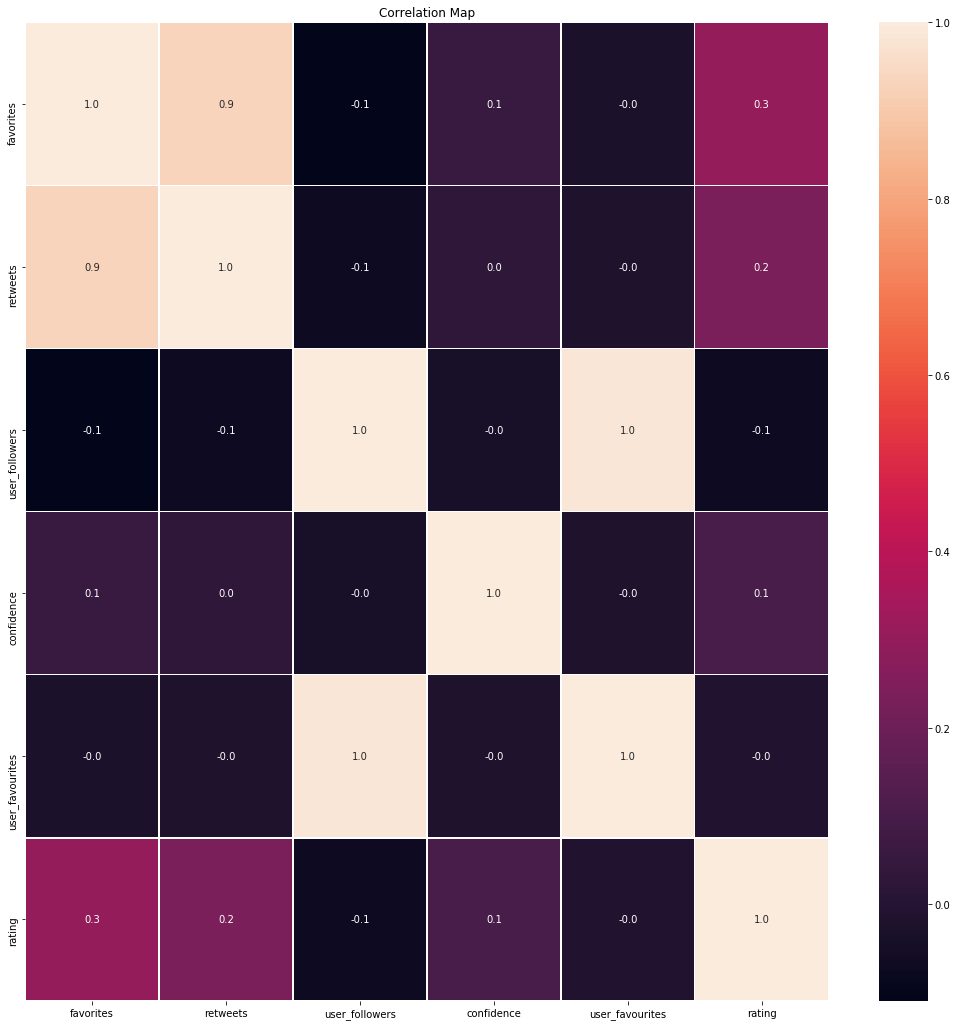

In [42]:
f,ax = plt.subplots(figsize=(18, 18))
sns.heatmap(df_master[['source', 'favorites','retweets',
                'user_followers','confidence',
                      'user_favourites','rating']].corr(), annot=True, linewidths=.5, fmt= '.1f',ax=ax)
plt.title('Correlation Map')
plt.savefig('Correlation.png')

- There is strong correlation between retweets and favourites. The dogs having more retweets, are more favourites which is as expected.
- We can see positive corelation of dog rating with favourties,retweets & confidence.
- User followers and favourites doesn't have much effect on each other

#### 2. How retweets and favourites are correlated for Popular breeds

In [43]:
#Grouping the top 8 breeds by their favourites score and assigning to dog_favorites variable
dog_favorites = df_master.groupby('breed')['favorites'].sum().sort_values(ascending=False).head(8)
dog_favorites

breed
golden_retriever      1858893
Labrador_retriever    1255254
Pembroke              1021658
Chihuahua              719039
French_bulldog         591775
Samoyed                562894
chow                   438498
cocker_spaniel         400368
Name: favorites, dtype: int64

In [44]:
#Grouping the top 8 breeds by their retweets score and assigning to variable dog_retweets 
dog_retweets = df_master.groupby('breed')['retweets'].sum().sort_values(ascending=False).head(8)
dog_retweets

breed
golden_retriever      547477
Labrador_retriever    389524
Pembroke              279688
Chihuahua             232193
Samoyed               192295
French_bulldog        155960
cocker_spaniel        140822
chow                  126062
Name: retweets, dtype: int64

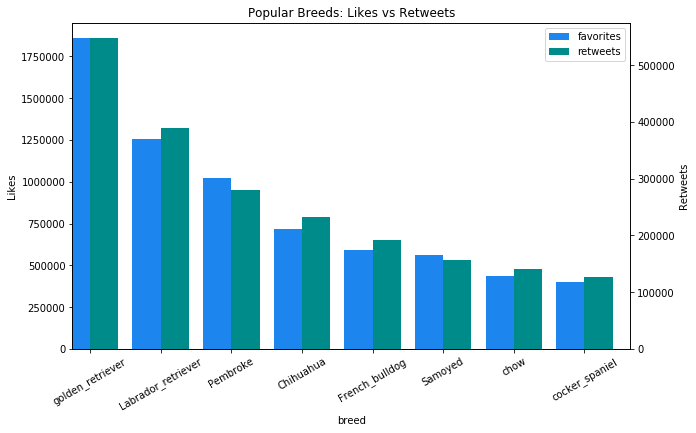

In [45]:
fig = plt.figure() # Creates matplotlib figure

ax = fig.add_subplot(111) # Creates matplotlib axes
ax2 = ax.twinx() # Creates another axes that shares the same x-axis as ax.

width = 0.4

dog_favorites.plot(figsize = (10,6), kind='bar', color='#1C86EE', ax=ax, width=width, position=1, title='Popular Breeds: Likes vs Retweets')
dog_retweets.plot(figsize = (10,6), kind='bar', color='#008B8B', ax=ax2, width=width, position=0)

# Turns off grid on the left Axis.
ax.grid(False)

# Turns off grid on the secondary (right) Axis.
ax2.grid(False)

ax.set_ylabel('Likes')
ax2.set_ylabel('Retweets')

ax.set_xticklabels(dog_favorites.index, rotation=30)

h1, l1 = ax.get_legend_handles_labels()
h2, l2 = ax2.get_legend_handles_labels()

plt.legend(h1+h2, l1+l2, loc=1)
plt.show()
plt.savefig('Popular_Breeds.png')

We can see from above plot that breed golden retriever is most popular with highest likes and retweets.

#### 3. How all the tweets are distributed in dataframe over the period of time

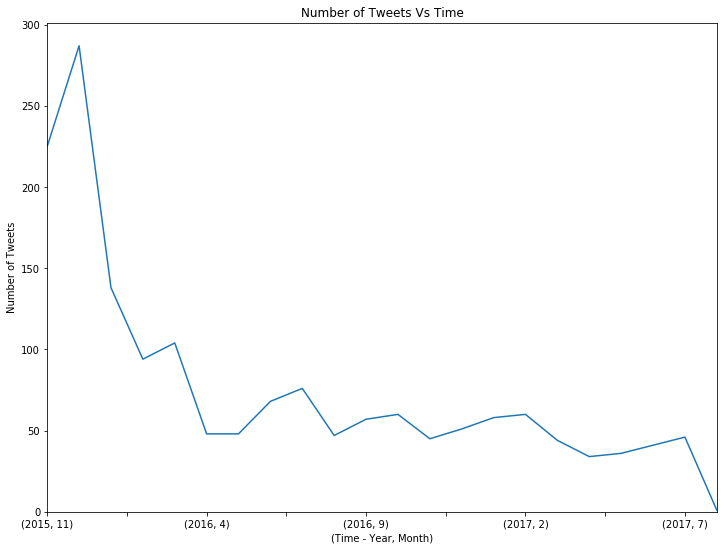

In [46]:
plt.rcParams["figure.figsize"] = [12, 9]
data = df_master.tweet_id.groupby([df_master["timestamp"].dt.year, df_master["timestamp"].dt.month]).count()
ax = data.plot('line', title='Number of Tweets Vs Time')
ax.set_xlabel("(Time - Year, Month)")
ax.set_ylabel("Number of Tweets")
ax.set_ylim(0, )
plt.savefig('tweet_trends')

It clearly shows that the tweets have been substantially decreased over the period of time. We can see fast increase of tweets when the #WeRateDog account just started but after that it is downfall in number of tweets as the time passes.

#### 4. Which dog_stage is having the a high proportion in the provided table

(-1.3152196293355578,
 1.2304343477800763,
 -1.1892043309943232,
 1.2047108916820504)

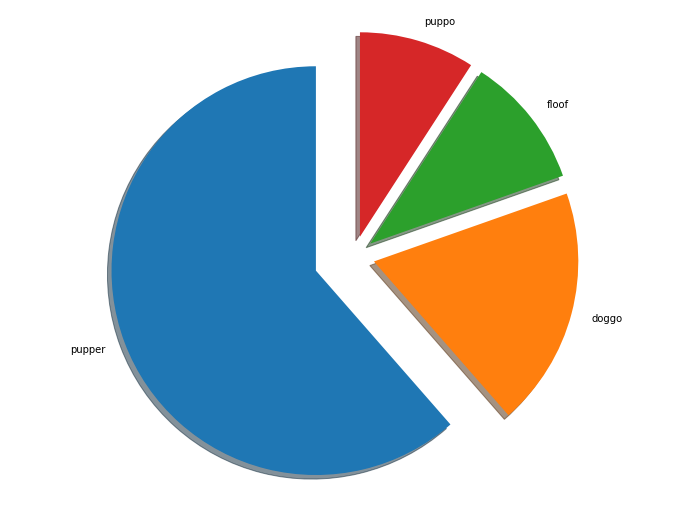

In [47]:
# Plot the data partitioned by dog stage
dog_stage_count = list(df_master[df_master['dog_stages'] != 'None']['dog_stages'].value_counts())[0:4]
dog_stages = df_master[df_master['dog_stages'] != 'None']['dog_stages'].value_counts().index.tolist()[0:4]
explode = (0.2, 0.1, 0.1, 0.1) 

fig1, ax1 = plt.subplots()
ax1.pie(dog_stage_count, explode = explode, labels = dog_stages, shadow = True, startangle = 90)
ax1.axis('equal')

Ok, so from above pie chart it is clear that more than half of the data is related to dog stage pupper. It would be interesting to see how the breed is divided in provided data with the given context of dog stage above.

#### 5. Which dog breed is having the highest distribution in provided data

Let's create another pie chart displaying the dog breed proportion

(-1.3020110348114706,
 1.2305555614256674,
 -1.2391766942374782,
 1.2035938901078009)

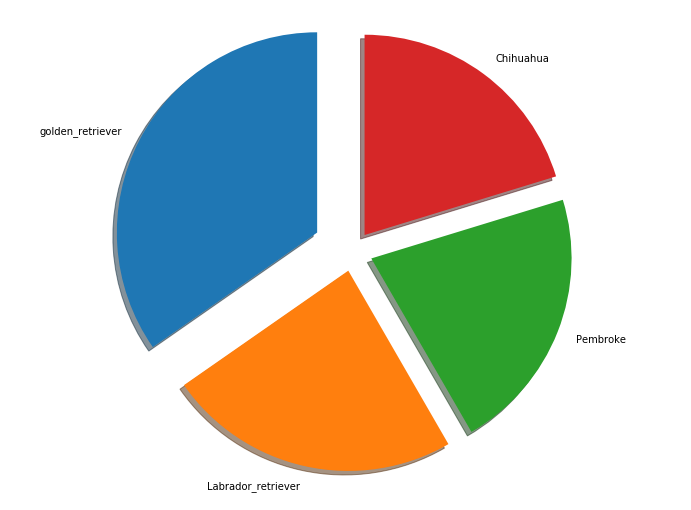

In [48]:
# Plot the data partitioned by dog stage
dog_stage_count = list(df_master[df_master['breed'] != 'Unidentifiable']['breed'].value_counts())[0:4]
dog_stages = df_master[df_master['breed'] != 'Unidentifiable']['breed'].value_counts().index.tolist()[0:4]
explode = (0.2, 0.1, 0.1, 0.1) 

fig1, ax1 = plt.subplots()
ax1.pie(dog_stage_count, explode = explode, labels = dog_stages, shadow = True, startangle = 90)
ax1.axis('equal')

Hmmm, golden retriever breed is more in the provided data 
which understandibly reflects as more favourite dog breed with high likes and retweets. Let's check first 10 breeds highest in numbers in provided data

In [49]:
breed_count = df_master['breed'].value_counts().head(10)
breed_count

golden_retriever      154
Labrador_retriever    105
Pembroke               95
Chihuahua              90
pug                    62
toy_poodle             51
chow                   47
Pomeranian             42
Samoyed                42
malamute               33
Name: breed, dtype: int64

Ok, we got the numbers but how these 10 breeds reflects in proportion in large picture. We will create pie chart this time with their propotion percentage

#### 6. What is the ratio of dog breeds in given data

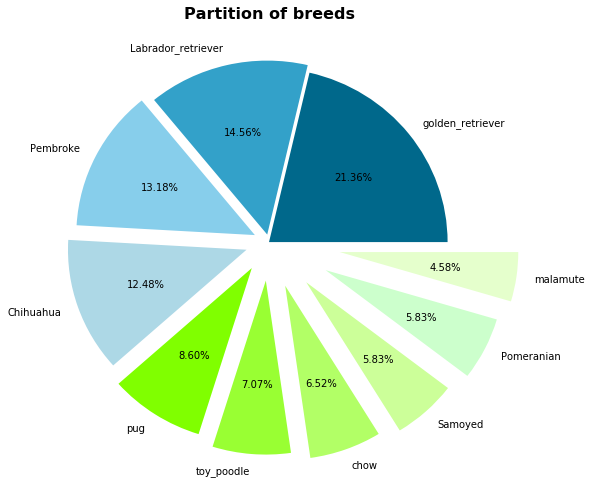

In [50]:
# Shows the repartition of the breeds with a pie chart.
explode = np.linspace(0,0.4,10)
colors = ['#00688B', '#33A1C9', '#87CEEB','#ADD8E6', '#80FF00', '#99FF33', '#B2FF66', '#CCFF99', '#CCFFCC', '#E5FFCC']
breed_count.sort_values(ascending=False).plot.pie(legend=False, subplots=True, autopct='%.2f%%', figsize=(8,8), explode=explode,colors = colors)
plt.ylabel('')
plt.title('Partition of breeds', weight='bold', fontsize=16)
plt.savefig('Breeds_Partition.png')

Clearly shows that golden_retriever is highest in numbers as compared to other breeds.More than half of the data is covered by golden_retriever, Labrador_retriever,Pembroke and Chihuahua.

#### 7. How much difference are in the ratings of high rated breeds. 

We can check it by taking the first 20 popular breeds to get wider picture for our analysis

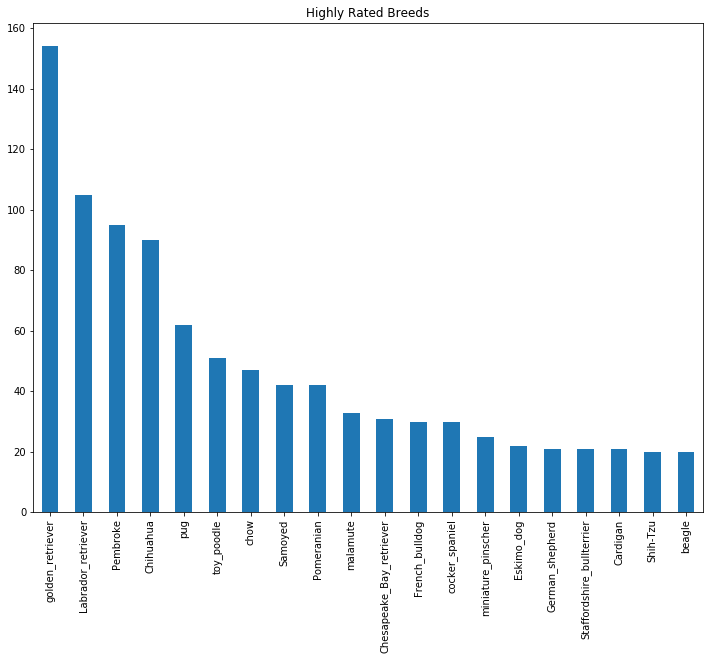

In [51]:
top=df_master.groupby('breed').filter(lambda x: len(x) >= 20)
top['breed'].value_counts().plot(kind = 'bar')
plt.title('Highly Rated Breeds');

golden retriever is almost 25% more popular than the second runner up Labrador_retriever. May be this breed is more commonly found & more adored in the area from where this data is retrieved,can be many such factors which are responsible for their popularity. The next 6 breed dogs are having gradual decline and other breeds more or less are contant in ratings. It would be interesting to check top 8 dogs with the highest retweets. Let's check this :

#### 8. Check top 8 most popular dogs and dog description

In [53]:
# first, we will get the highest 10 values for the retweet count in our dataframe
top_8_retweets = df_master['retweets'].nlargest(8, keep='first')

# filter the dataframe to get only the records with the highest 8 retweets count in the dataframe
most_popular_dogs = df_master[df_master['retweets'].isin(top_8_retweets)]

# Sort the results descendingly by "retweet_count" field
most_popular_dogs = most_popular_dogs.sort_values(by=['retweets'], ascending=False)

most_popular_dogs

,tweet_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,rating,name,favorites,retweets,user_followers,user_favourites,jpg_url,img_num,dog_stages,breed,confidence
846,744234799360020481,2016-06-18 18:26:18,"<a href=""http://twitter.com/download/iphone"" r...",Here's a doggo realizing you can stand in a po...,https://twitter.com/dog_rates/status/744234799...,13.0,10.0,1.3,NaN,164966,84148,7431639,139602,https://pbs.twimg.com/ext_tw_video_thumb/74423...,1,doggo,Labrador_retriever,0.825333
881,739238157791694849,2016-06-04 23:31:25,"<a href=""http://twitter.com/download/iphone"" r...",Here's a doggo blowing bubbles. It's downright...,https://twitter.com/dog_rates/status/739238157...,13.0,10.0,1.3,NaN,121961,62329,7431639,139602,https://pbs.twimg.com/ext_tw_video_thumb/73923...,1,doggo,Eskimo_dog,0.503372
428,807106840509214720,2016-12-09 06:17:20,"<a href=""http://twitter.com/download/iphone"" r...",This is Stephan. He just wants to help. 13/10 ...,https://twitter.com/dog_rates/status/807106840...,13.0,10.0,1.3,Stephan,127649,61334,7431633,139602,https://pbs.twimg.com/ext_tw_video_thumb/80710...,1,None,Chihuahua,0.505370
325,822872901745569793,2017-01-21 18:26:02,"<a href=""http://twitter.com/download/iphone"" r...",Here's a super supportive puppo participating ...,https://twitter.com/dog_rates/status/822872901...,13.0,10.0,1.3,NaN,141056,47999,7431633,139602,https://pbs.twimg.com/media/C2tugXLXgAArJO4.jpg,1,puppo,Lakeland_terrier,0.196015
59,879415818425184262,2017-06-26 19:07:24,"<a href=""http://twitter.com/download/iphone"" r...",This is Duddles. He did an attempt. 13/10 some...,https://twitter.com/dog_rates/status/879415818...,13.0,10.0,1.3,Duddles,104488,43662,7431630,139602,https://pbs.twimg.com/ext_tw_video_thumb/87941...,1,None,English_springer,0.383404
354,819004803107983360,2017-01-11 02:15:36,"<a href=""http://twitter.com/download/iphone"" r...",This is Bo. He was a very good First Doggo. 14...,https://twitter.com/dog_rates/status/819004803...,14.0,10.0,1.4,Bo,92344,40256,7431633,139602,https://pbs.twimg.com/media/C12whDoVEAALRxa.jpg,1,doggo,standard_poodle,0.351308
431,806629075125202948,2016-12-07 22:38:52,"<a href=""http://twitter.com/download/iphone"" r...","""Good afternoon class today we're going to lea...",https://twitter.com/dog_rates/status/806629075...,13.0,10.0,1.3,NaN,80773,38481,7431633,139602,https://pbs.twimg.com/media/CzG425nWgAAnP7P.jpg,2,None,cocker_spaniel,0.046403
111,866450705531457537,2017-05-22 00:28:40,"<a href=""http://twitter.com/download/iphone"" r...",This is Jamesy. He gives a kiss to every other...,https://twitter.com/dog_rates/status/866450705...,13.0,10.0,1.3,Jamesy,122489,35651,7431631,139602,https://pbs.twimg.com/media/DAZAUfBXcAAG_Nn.jpg,2,pupper,French_bulldog,0.905334


Wow! here Labrador retriever breed got the first place in retweets and popularity. I am sure all of these 8 dogs must be cute. I would like to see how they look so let's check their picture in above order.

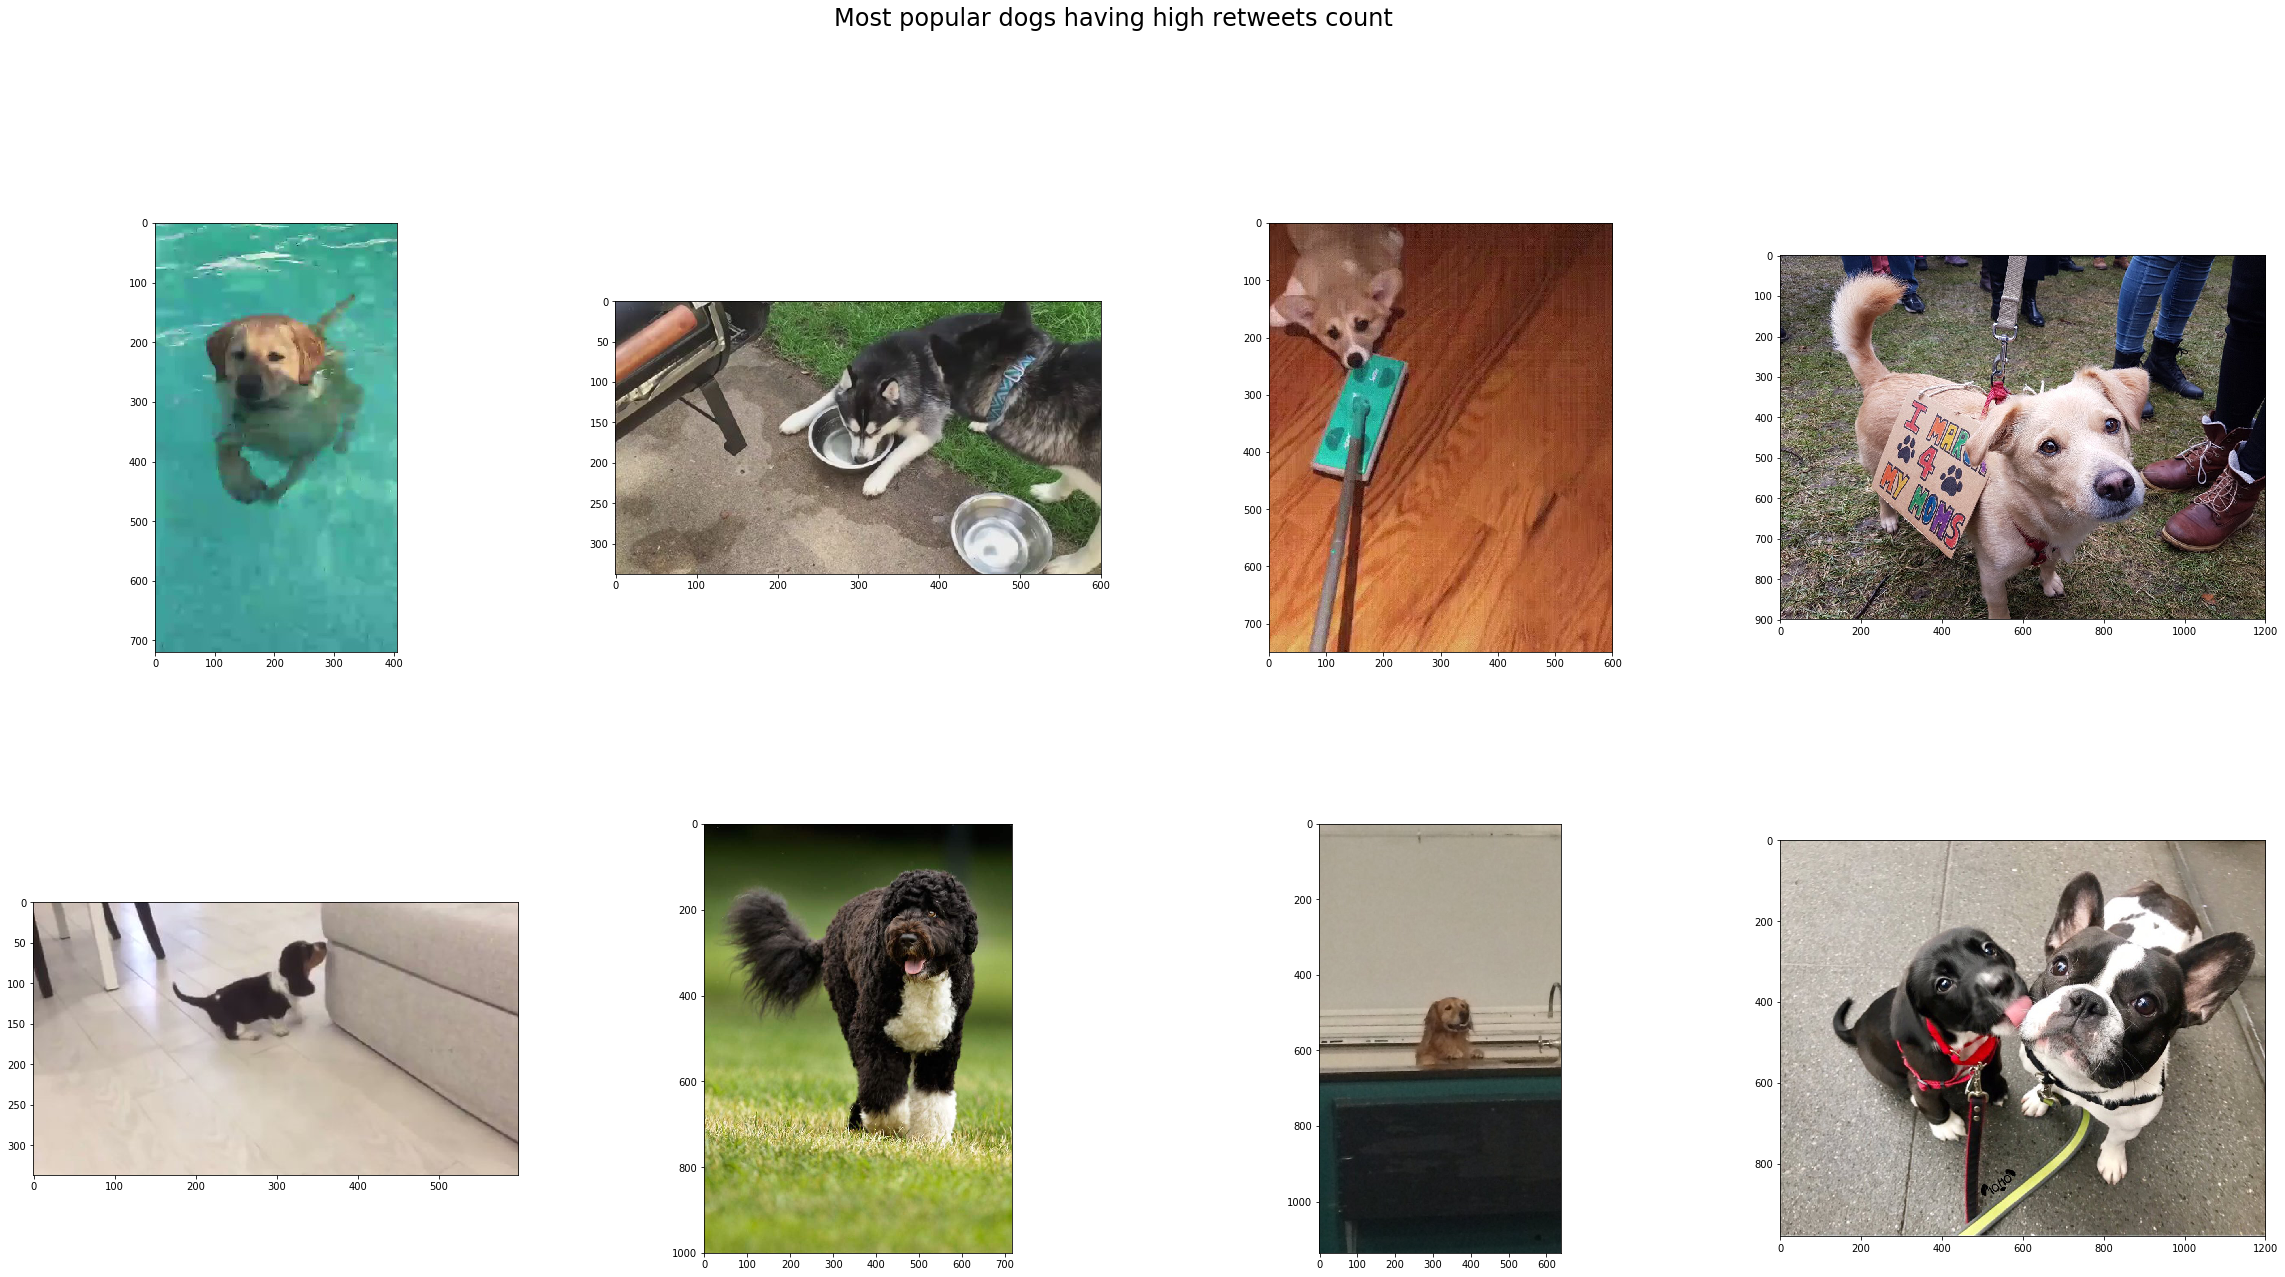

In [54]:
fig = plt.figure(figsize=(40,30))
fig.suptitle("Most popular dogs having high retweets count", fontsize=24)
columns = 4
idx = 0
fig.subplots_adjust(hspace=0.4)

for i, row in most_popular_dogs.iterrows():
    img_url = row['jpg_url']
    image = io.imread(img_url)
    plt.subplot(most_popular_dogs.shape[0] / columns + 1, columns, idx + 1)
    plt.imshow(image)
    idx += 1

Aww! These are very cute dogs and no surprize that they are top 8 popular dogs.